In [1]:
#default_exp reproj

# Data Transformation

<br>

### Imports

In [2]:
#exports
import json
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import os
import time
from itertools import product
from collections import OrderedDict
from datetime import datetime
from ipypb import track
import FEAutils as hlp

import satpy
from satpy import Scene
from satpy.readers import seviri_l1b_native
import pyresample
from pyresample.geometry import AreaDefinition

# pyinterp fails to import on some machines for unknown reasons - leave it optional
try:
    import pyinterp
    import pyinterp.backends.xarray
except:
    pass


<br>

We'll separately install libraries that wont be needed for the `satip` module

In [3]:
import rasterio
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling, calculate_default_transform, transform
from rasterio.control import GroundControlPoint
from rasterio.transform import xy

import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs

from IPython.display import JSON

<br>

### User Input

In [4]:
data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'

calculate_reproj_coords = False

<br>

### Exploratory Data Analysis

We'll start by identifying the available files

In [5]:
native_fps = sorted([f'{data_dir}/{f}' for f in os.listdir(data_dir) if '.nat' in f])

native_fps[0]

'../data/raw/MSG3-SEVI-MSG15-0100-NA-20210121204918.196000000Z-NA.nat'

<br>

Then load one of them in as a SatPy scene

In [6]:
native_fp = native_fps[0]

scene = Scene(filenames=[native_fp], reader='seviri_l1b_native')

scene

<br>

We can get a list of the available datasets (bands)

In [7]:
scene.all_dataset_names()

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

<br>

Each band contains an XArray DataArray

In [8]:
scene.load(['HRV'])

scene['HRV']

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<xarray.DataArray 'reshape-d4e0a459824b09e38634d18c1de710b4' (y: 4176, x: 5568)>
dask.array<mul, shape=(4176, 5568), dtype=float32, chunksize=(1392, 5568), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 1.395e+06 1.396e+06 1.397e+06 ... 5.57e+06 5.571e+06
  * x        (x) float64 2.83e+06 2.829e+06 2.828e+06 ... -2.736e+06 -2.737e+06
Attributes:
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   0.9683646614038233
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-10
    sensor:                                 seviri
    start_time:                             2021-01-21 20:45:11.814324
    end_time:                               2021-01-21 20:50:10.471270
    area:                                   Area ID: geos_seviri_hrv\nDescrip...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

<br>

We can see that the DataArray contains a crs, however we'll make our own custom area definition that's more accurate. First we'll create a helper function that will create our area definitions.

In [9]:
#exports
def calculate_x_offset(native_fp):
    handler = seviri_l1b_native.NativeMSGFileHandler(native_fp, {}, None)
    lower_east_column_planned = handler.header['15_DATA_HEADER']['ImageDescription']['PlannedCoverageHRV']['LowerEastColumnPlanned']
    x_offset = 32500 + ((2733 - lower_east_column_planned) * 1000)

    return x_offset

def get_seviri_area_def(native_fp, num_x_pixels=5568, num_y_pixels=4176) -> AreaDefinition:
    """
    The HRV channel on Meteosat Second Generation satellites doesn't scan the full number of columns.
    The east boundary of the HRV channel changes (e.g. to maximise the amount of the image which
    is illuminated by sunlight.
    
    Parameters:
        native_fp: Data filepath
        

    """
    
    x_offset = calculate_x_offset(native_fp)
    
    # The EUMETSAT docs say "The distance between spacecraft and centre of earth is 42,164 km. The idealized earth
    # is a perfect ellipsoid with an equator radius of 6378.1690 km and a polar radius of 6356.5838 km." 
    # The projection used by SatPy expresses height as height above the Earth's surface (not distance
    # to the centre of the Earth).
    
    projection = {
        'proj': 'geos',
        'lon_0': 9.5,
        'a': 6378169.0,
        'b': 6356583.8,
        'h': 35785831.00,
        'units': 'm'}

    seviri = AreaDefinition(
        area_id='seviri',
        description='SEVIRI RSS HRV',
        proj_id='seviri',   
        projection=projection,
        width=num_x_pixels,
        height=num_y_pixels,
        area_extent=[
            -2768872.0236 + x_offset, # left
             1394687.3495,            # bottom (from scene['HRV'].area)
             2799876.1893 + x_offset, # right
             5570248.4773]            # top (from scene['HRV'].area)
    )

    return seviri

<br>

Then we'll use it to construct the relevant one for Seviri

In [10]:
seviri = get_seviri_area_def(native_fp)
seviri_crs = seviri.to_cartopy_crs()

seviri_crs

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


_PROJ4Projection(+ellps=WGS84 +a=6378169.0 +rf=295.488065897001 +h=35785831.0 +lon_0=9.5 +no_defs=True +proj=geos +type=crs +units=m +x_0=0.0 +y_0=0.0 +no_defs)

<br>

We'll create a loader function that will extract the relevant data for `lower_east_column_planned` automatically

In [11]:
#exports
def load_scene(native_fp):
    # Reading scene and loading HRV
    scene = Scene(filenames=[native_fp], reader='seviri_l1b_native')

    # Identifying and recording lower_east_column_planned
    handler = seviri_l1b_native.NativeMSGFileHandler(native_fp, {}, None)
    scene.attrs['lower_east_column_planned'] = handler.header['15_DATA_HEADER']['ImageDescription']['PlannedCoverageHRV']['LowerEastColumnPlanned']
    
    return scene

<br>

We'll see how quickly this loads

In [12]:
%%time

scene = load_scene(native_fp)
scene.load(['HRV'])

Wall time: 779 ms


C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<br>

We can visualise what a specific band looks like

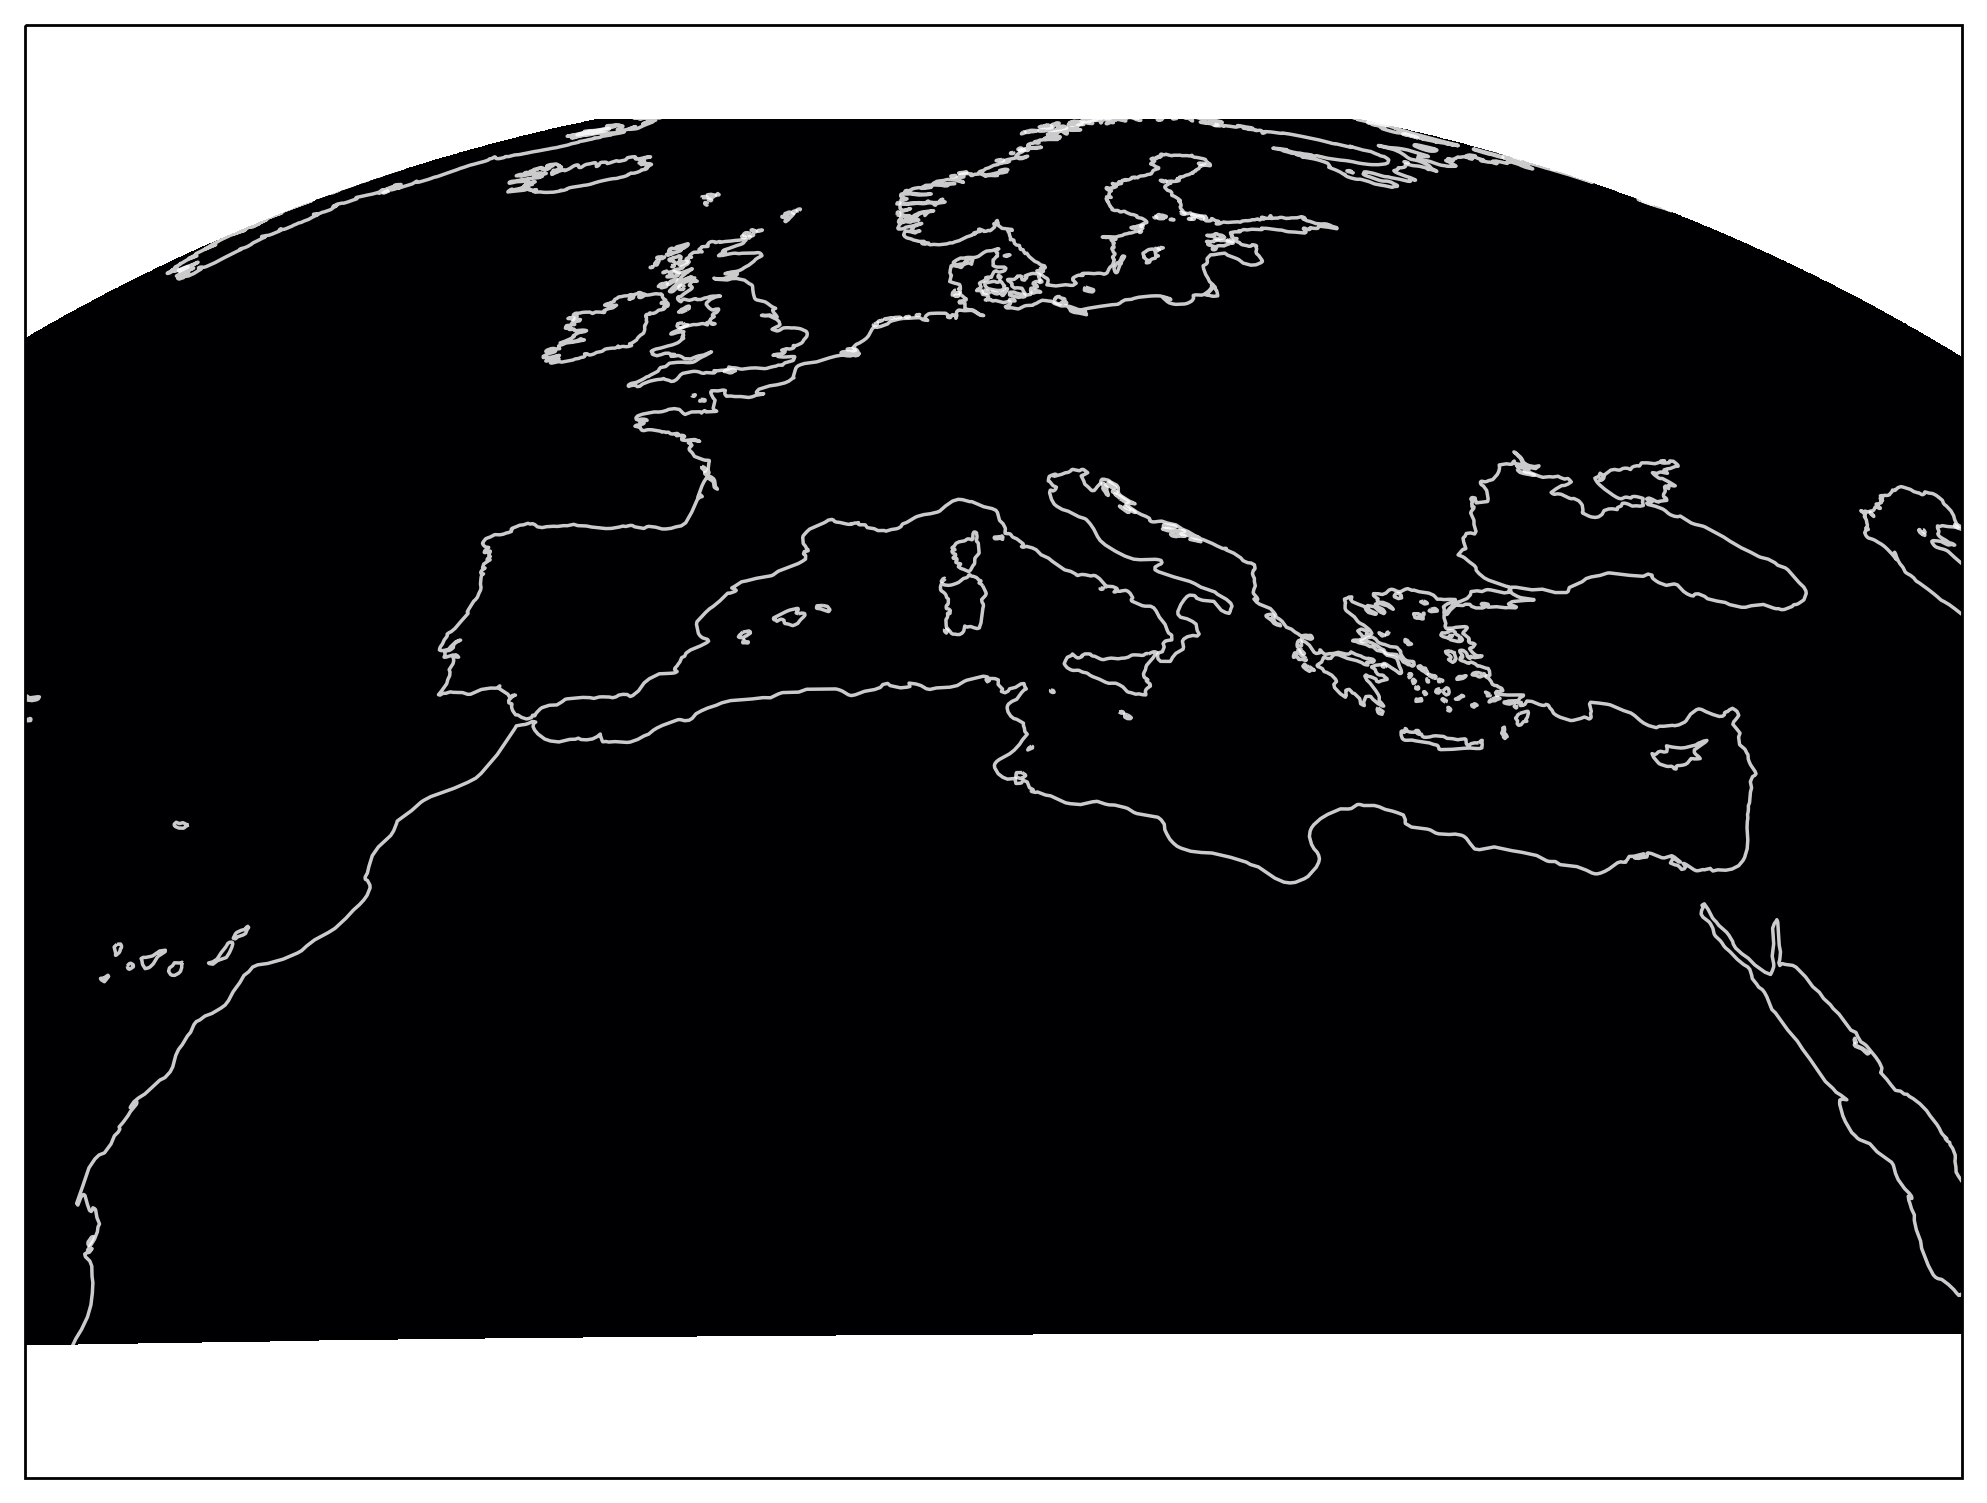

In [13]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=seviri_crs)

scene['HRV'].plot.imshow(ax=ax, add_colorbar=False, cmap='magma', vmin=0, vmax=50)

ax.set_title('')
ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

One of the benefits of having access to the underlying XArray object is that we can more easily start to do some analysis with the data, for example defining a reflectance threshold

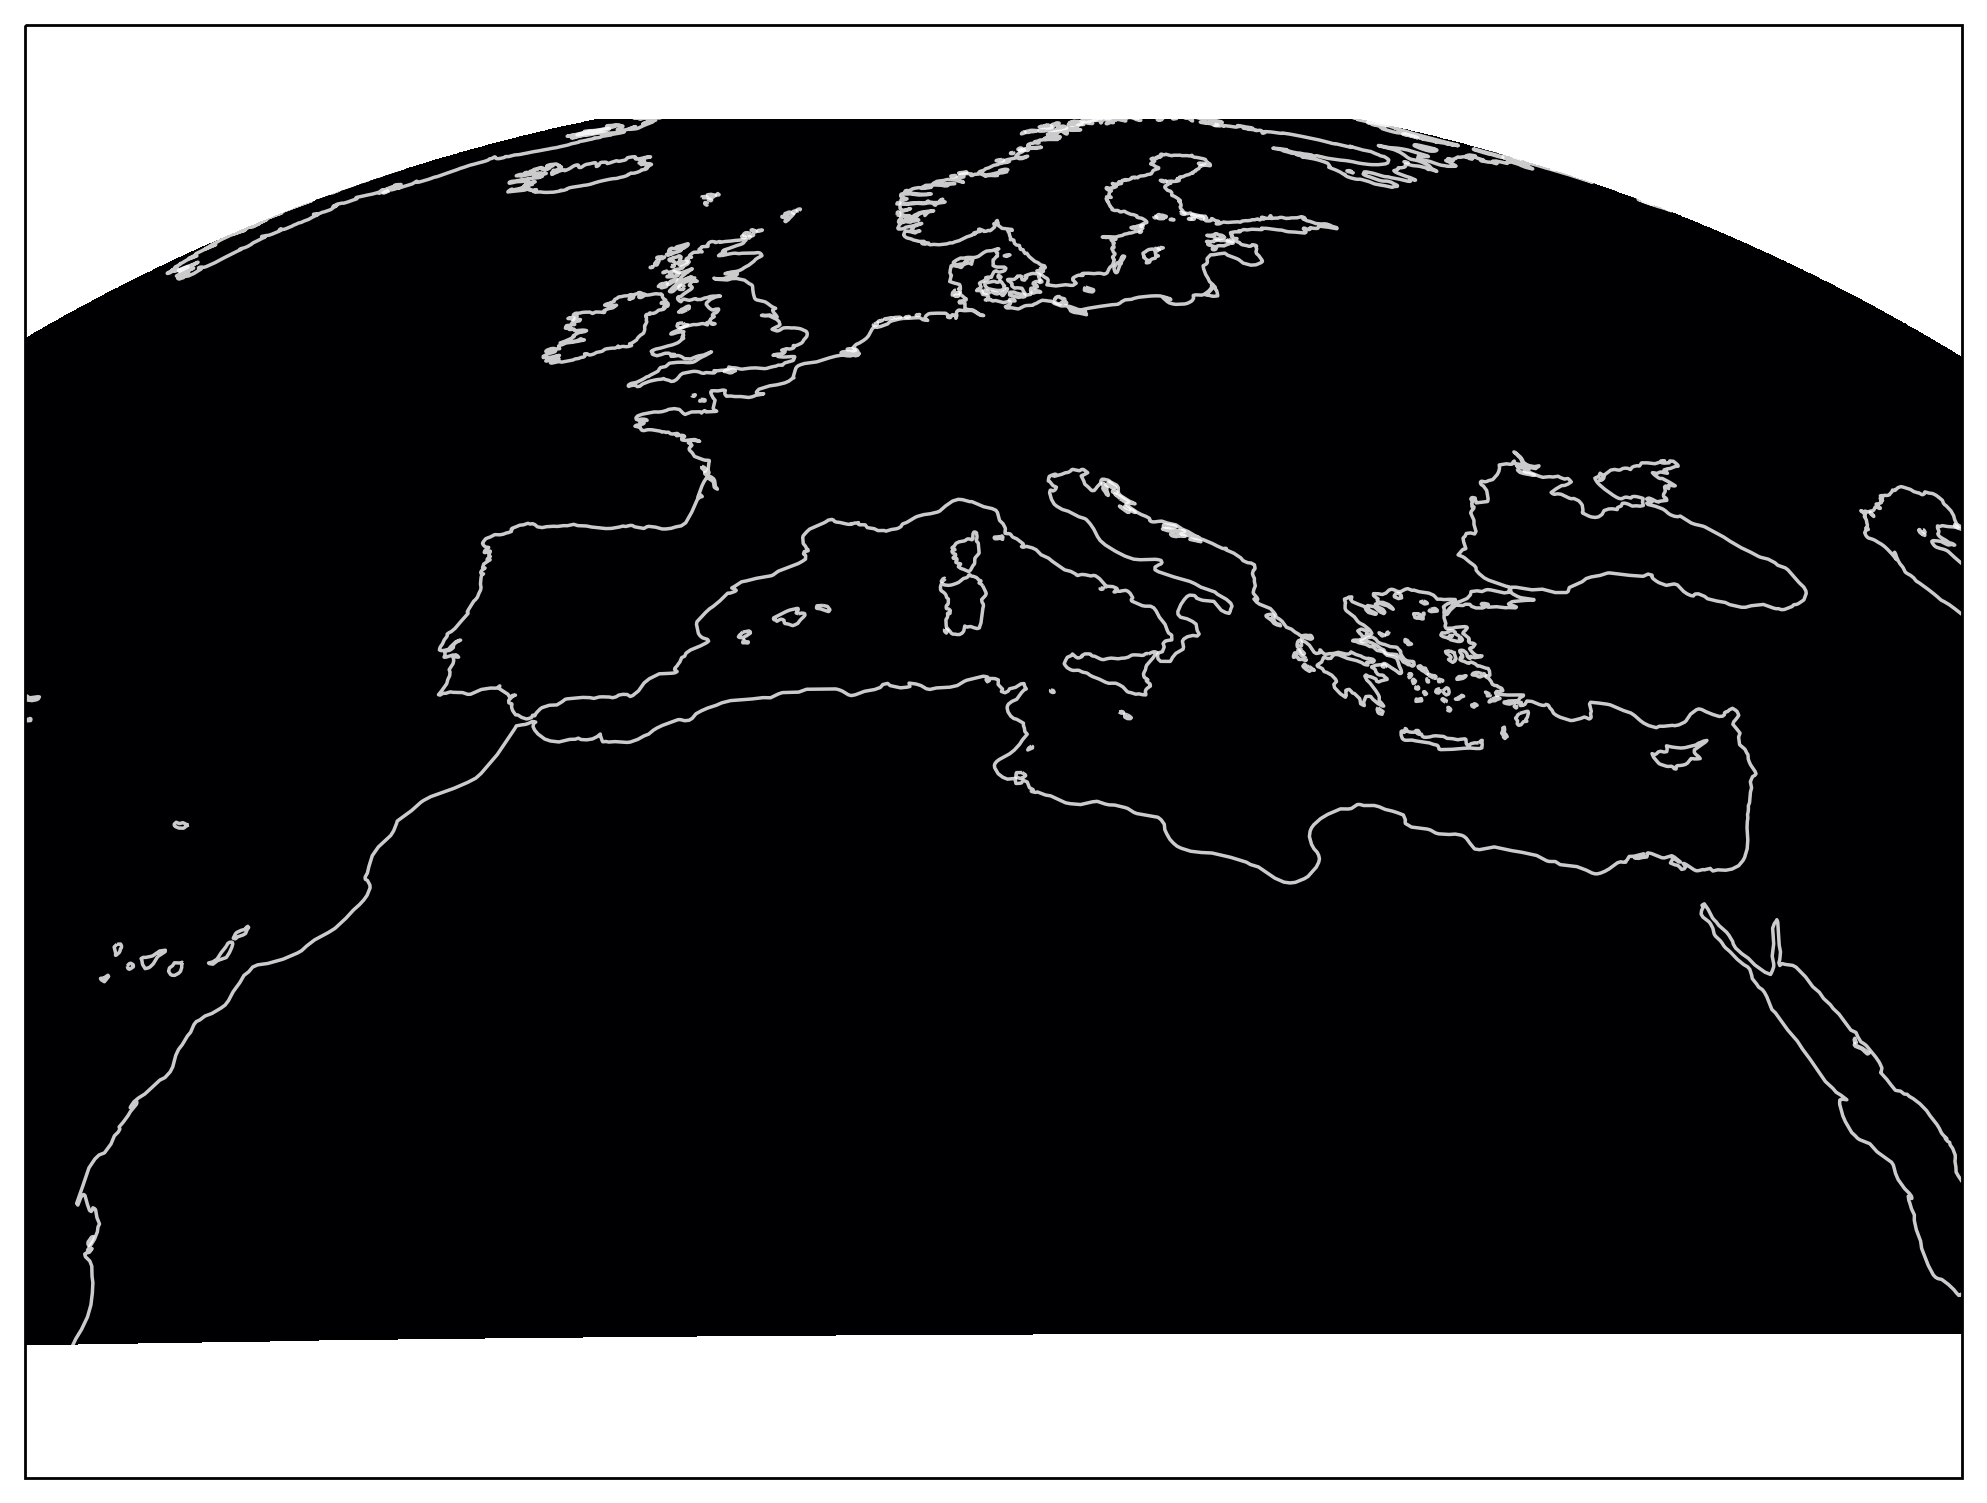

In [14]:
reflectance_threshold = 35

cmap = colors.ListedColormap([
    (0, 0, 0, 0), # transparent
    (251/255, 242/255, 180/255, 1) # yellow
#     (0.533, 0.808, 0.922, 1) # grey-like blue
])

# Plotting
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=seviri_crs)

scene['HRV'].plot.imshow(ax=ax, vmin=0, vmax=50, cmap='magma', add_colorbar=False)
(scene['HRV']>reflectance_threshold).plot.imshow(ax=ax, cmap=cmap, add_colorbar=False)

ax.set_title('')
ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

We'll extract the values from the XArray object, then mask all NaN values to enable us to carry out statistical analysis

In [15]:
HRV = scene["HRV"].values
HRV_masked = ma.masked_array(HRV, mask=xr.ufuncs.isnan(scene["HRV"]).values)

np.mean(HRV_masked)

0.03837633008116254

<br>

We can also visualise the full distribution.

N.b. to reduce the time it takes to calculate the best KDE fit we'll take only a sample of the data.

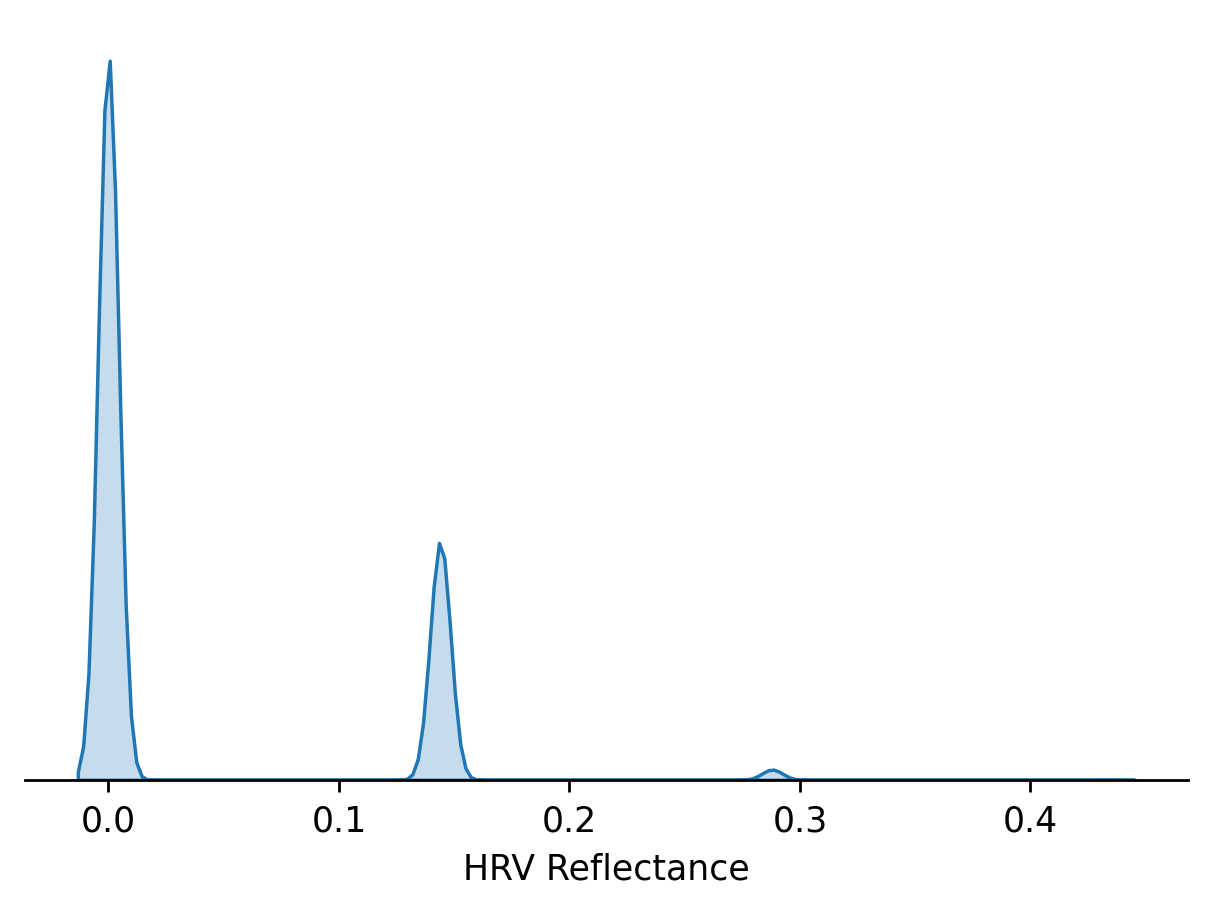

In [16]:
HRV_sample = np.random.choice(HRV_masked.flatten(), 1_000_000)

# Plotting
fig, ax = plt.subplots(dpi=250)

sns.kdeplot(HRV_sample, ax=ax, fill=True)

ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('HRV Reflectance')
hlp.hide_spines(ax, positions=['top', 'left', 'right'])

<br>

### Evaluating Reprojection to Tranverse Mercator

Before we can resample we need to define the area we're resampling to, we'll write a constructor to help us do this

In [17]:
#exports
def construct_area_def(scene, area_id, description,
                       proj_id, projection,
                       west, south, east, north,
                       pixel_size=None):

    # If None then will use same number of x and y points
    # HRV's resolution will be more like 4km for Europe
    if pixel_size is not None:
        width = int((east - west) / pixel_size)
        height = int((north - south) / pixel_size)
    else:
        width = scene[list(scene.keys())[0]['name']].x.values.shape[0]
        height = scene[list(scene.keys())[0]['name']].y.values.shape[0]

    area_extent = (west, south, east, north)

    area_def = AreaDefinition(area_id, description,
                              proj_id, projection,
                              width, height, area_extent)

    return area_def

def construct_TM_area_def(scene):
    meters_per_pixel = 4000 
    west, south, east, north = (-3090000, 1690000, 4390000, 9014000)

    area_id = 'TM'
    description = 'Transverse Mercator' 
    proj_id = 'TM'

    projection = {
        'ellps': 'WGS84',
        'proj': 'tmerc',  # Transverse Mercator
        'units': 'm'  # meters
    }

    tm_area_def = construct_area_def(scene, area_id, description,
                                     proj_id, projection,
                                     west, south, east, north,
                                     meters_per_pixel)
    
    return tm_area_def

In [18]:
tm_area_def = construct_TM_area_def(scene)

tm_area_def.to_cartopy_crs()

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


_PROJ4Projection(+ellps=WGS84 +k=1.0 +lat_0=0.0 +lon_0=0.0 +no_defs=True +proj=tmerc +type=crs +units=m +x_0=0.0 +y_0=0.0 +no_defs)

<br>

We can now carry out the resampling using the `pyresample` library

In [19]:
%%time

resampled_scene = scene.resample(tm_area_def, resampler='nearest')

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyresample\spherical.py:123: RuntimeWarning: invalid value encountered in true_divide
  self.cart /= np.sqrt(np.einsum('...i, ...i', self.cart, self.cart))
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyresample\spherical.py:178: RuntimeWarning: invalid value encountered in double_scalars
  return (val + mod) % (2 * mod) - mod
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Wall time: 4.81 s


<br>

We'll quickly check that the reprojection looks ok

<ipython-input-20-ec0e500c536a>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


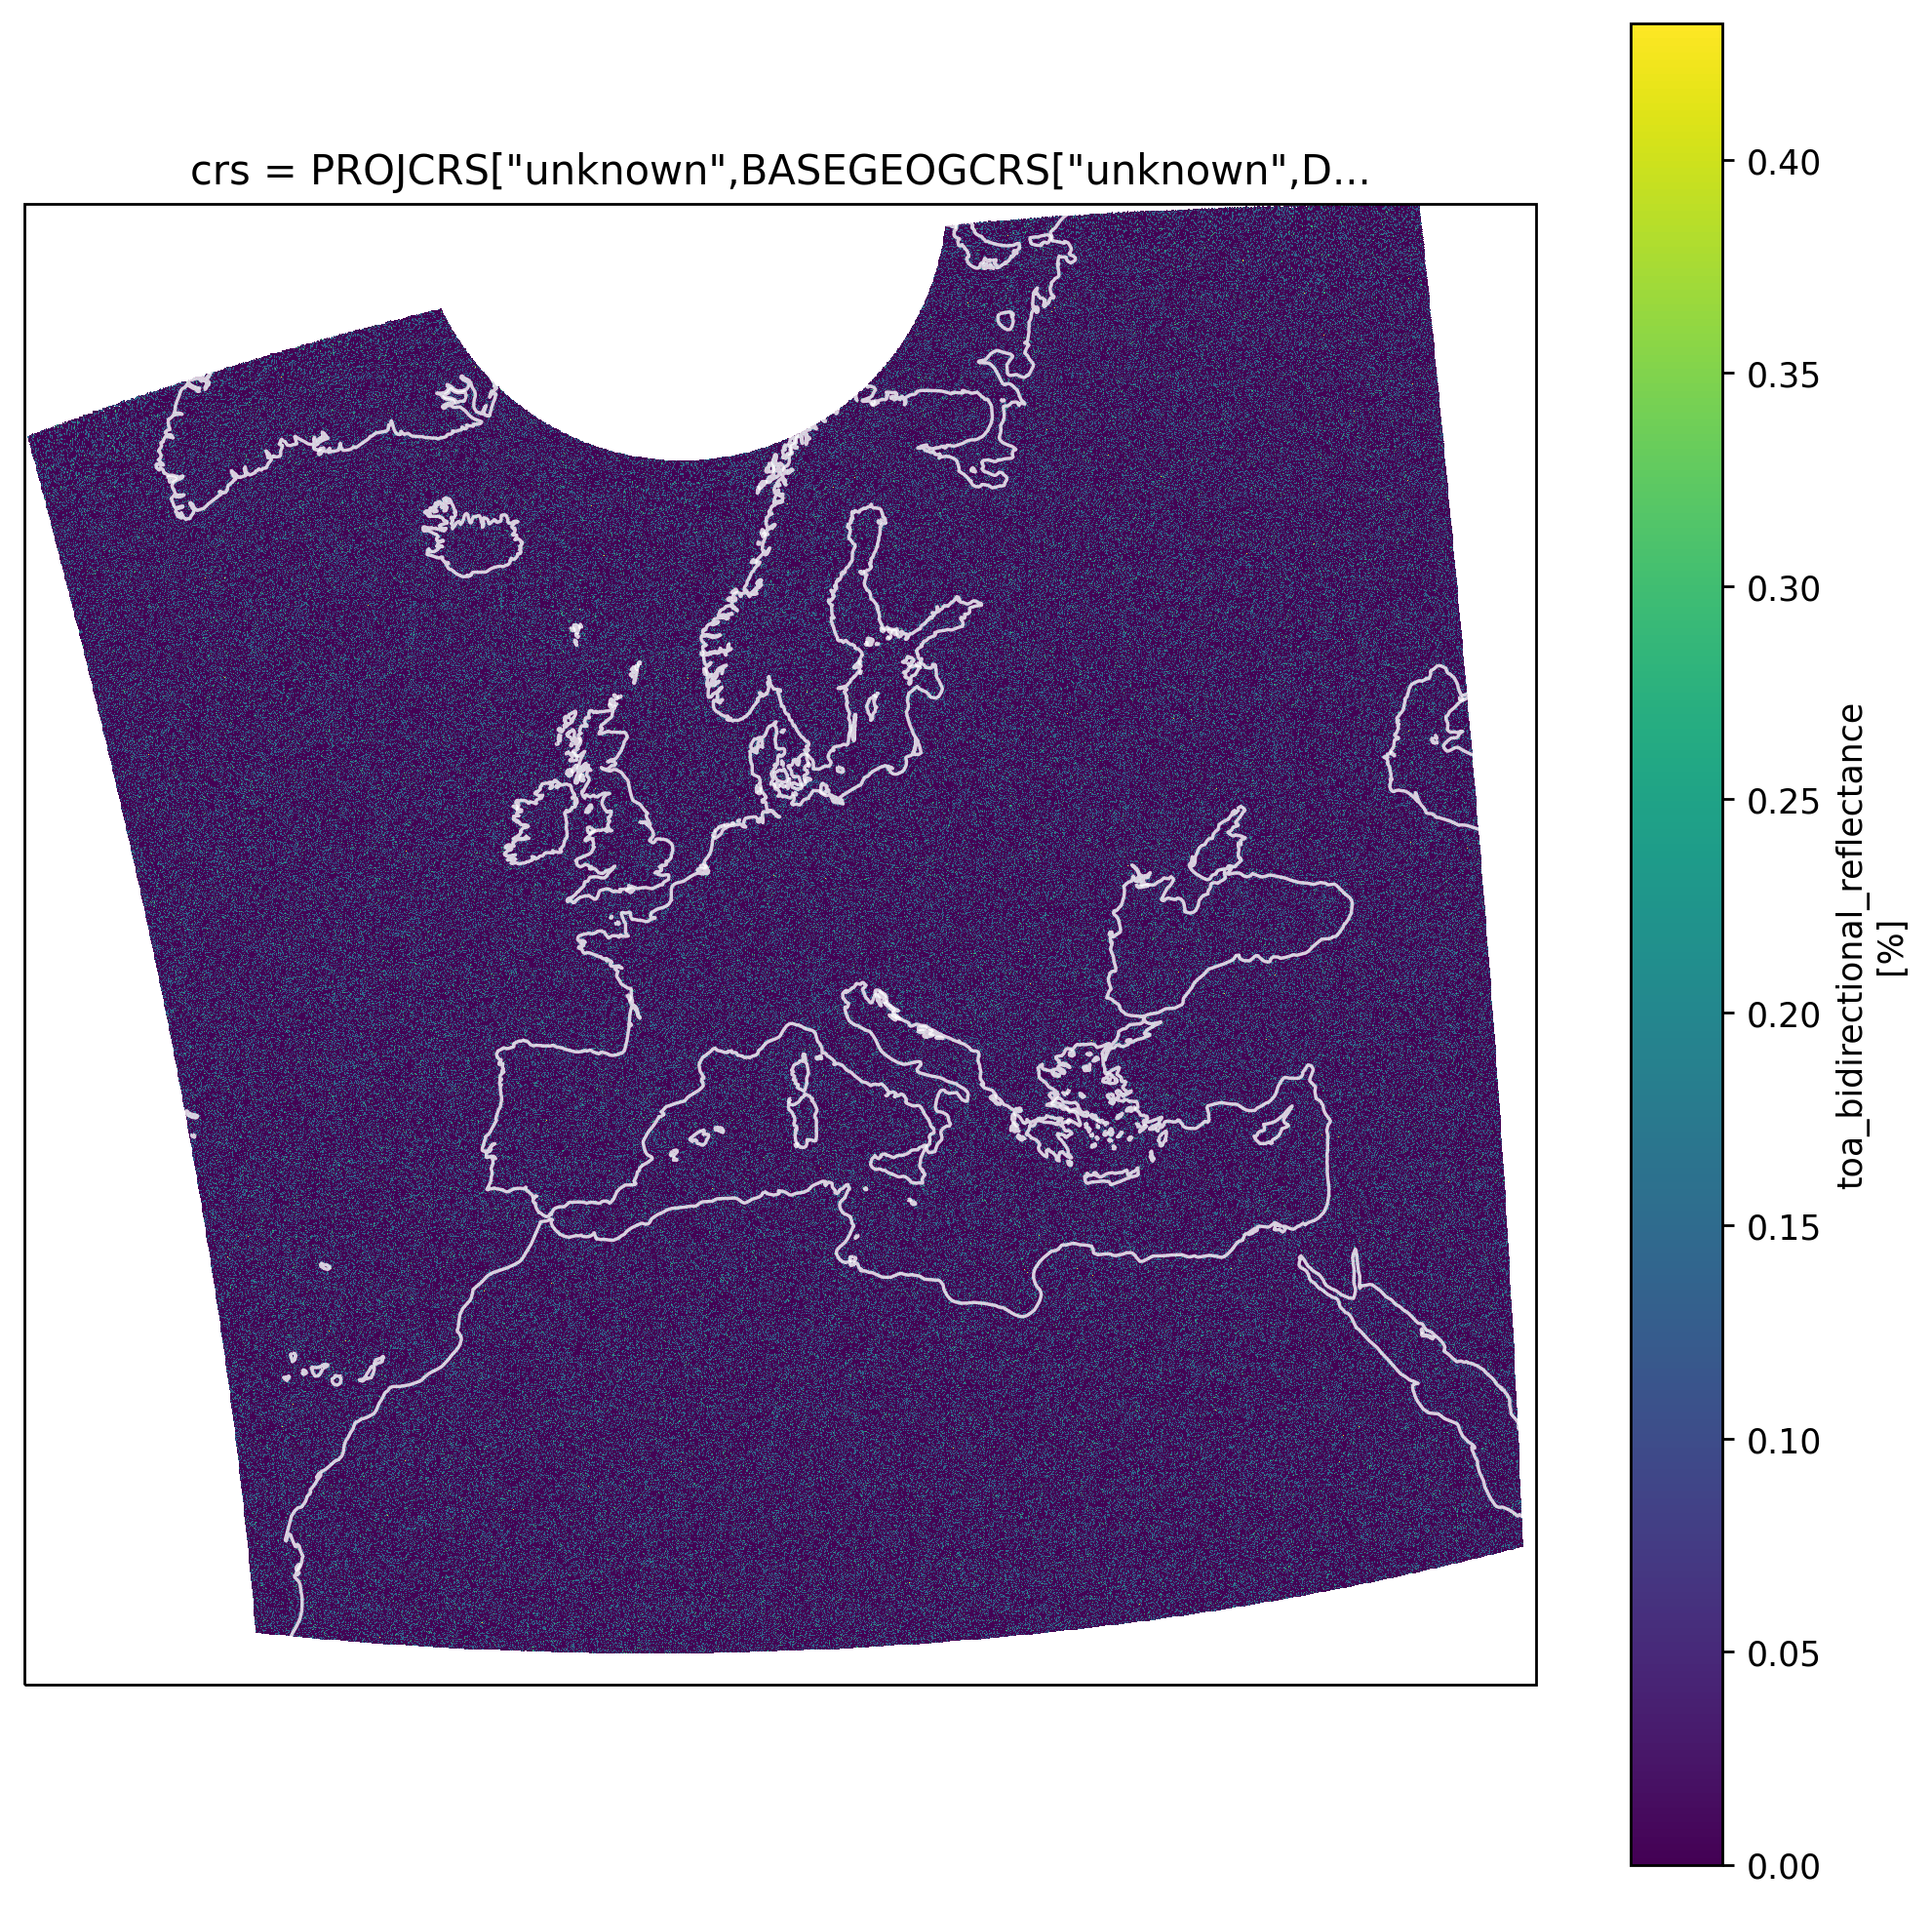

In [20]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

resampled_scene['HRV'].plot.imshow(ax=ax)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

We want to gain a deeper understanding of the reprojection that's being carried out, to do this we'll manually reproject a sample of the original gridded coordinates

In [21]:
%%time

orig_x_values = scene['HRV'].x.values[::50]
orig_y_values = scene['HRV'].y.values[::50]

XX, YY = np.meshgrid(orig_x_values, orig_y_values)

df_proj_points = (gpd
                    .GeoSeries([
                        Point(x, y) 
                        for x, y 
                        in np.stack([XX.flatten(), YY.flatten()], axis=1)
                    ])
                    .set_crs(crs=scene['HRV'].area.crs_wkt)
                    .to_crs(crs=resampled_scene['HRV'].area.crs_wkt)
                    .apply(lambda point: pd.Series(list(point.coords)[0]))
                    .rename(columns={0: 'x_reproj', 1: 'y_reproj'})
                    .replace(np.inf, np.nan)
                    .pipe(lambda df: df.assign(x_orig=XX.flatten()))
                    .pipe(lambda df: df.assign(y_orig=YY.flatten()))
                   )

df_proj_points.head()

Wall time: 8.13 s


x_reproj      y_reproj        x_orig        y_orig
0  4.339496e+06  1.807258e+06  2.830380e+06  1.395187e+06
1  4.265540e+06  1.792909e+06  2.780373e+06  1.395187e+06
2  4.192607e+06  1.779055e+06  2.730367e+06  1.395187e+06
3  4.120656e+06  1.765672e+06  2.680360e+06  1.395187e+06
4  4.049647e+06  1.752740e+06  2.630353e+06  1.395187e+06

<br>

We can then visualise the reprojection of the original grid against the regridded reprojection

<timed exec>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))


Wall time: 20.8 s


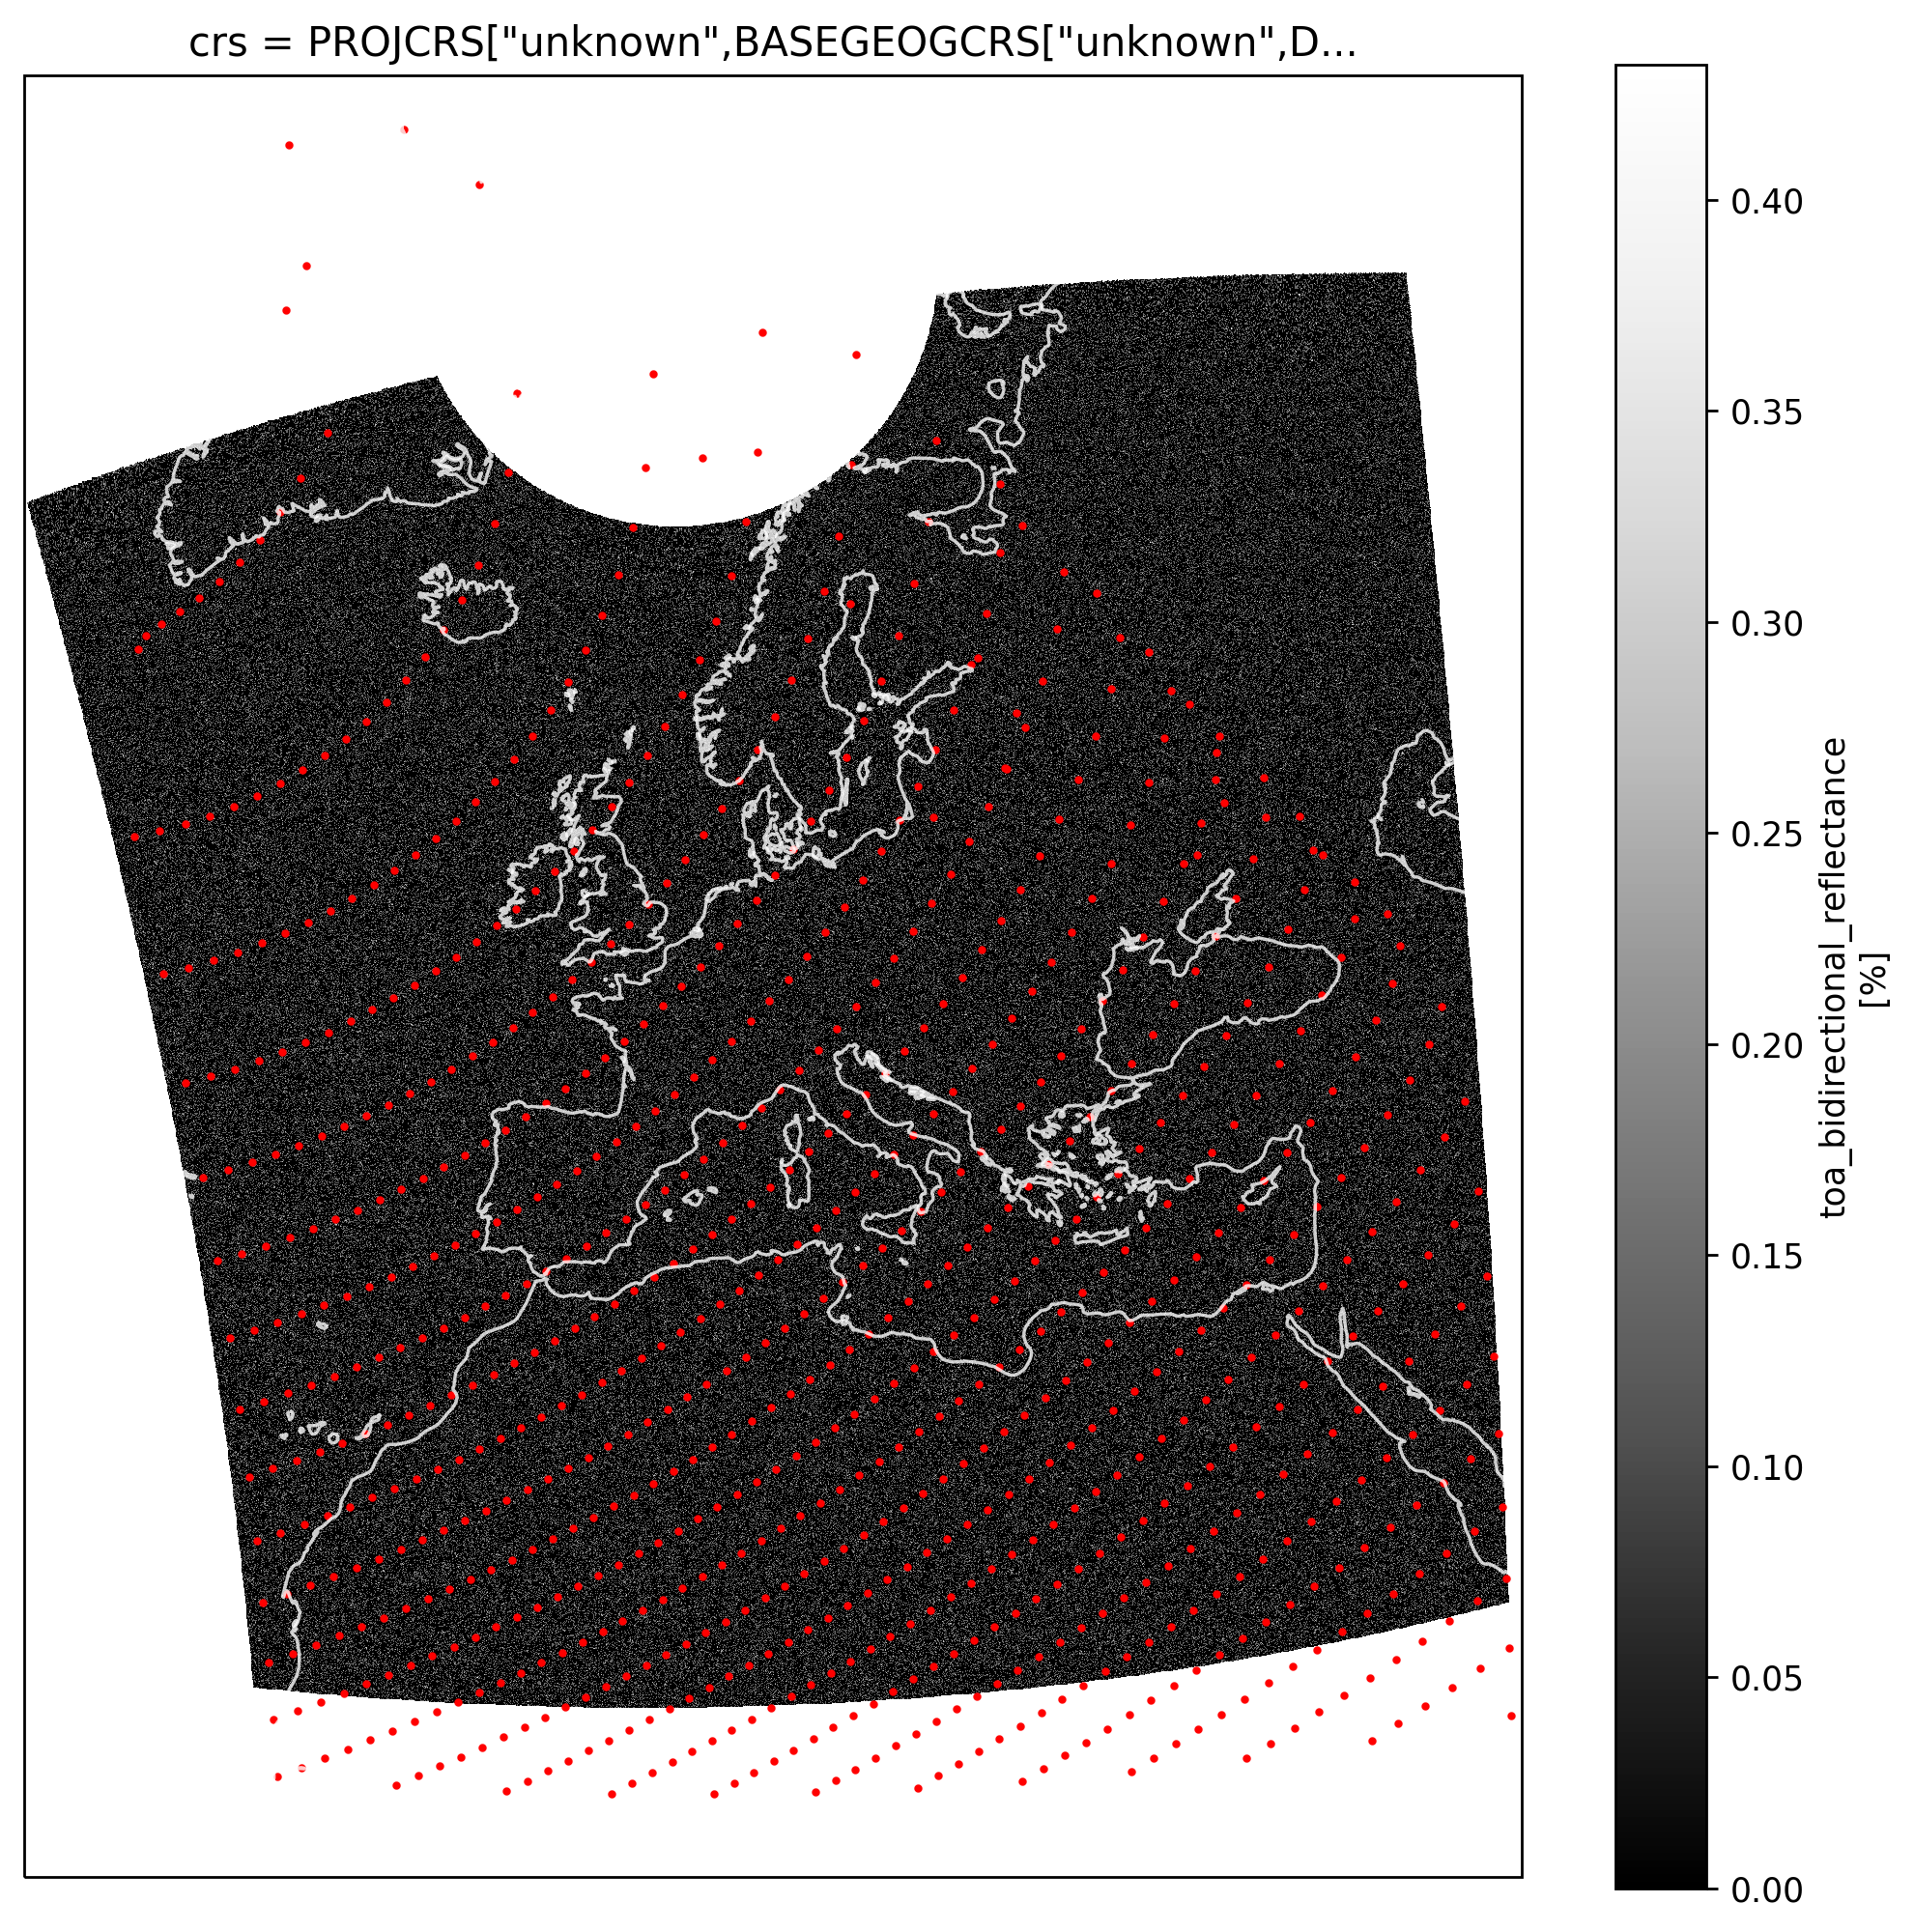

In [22]:
%%time

fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

resampled_scene['HRV'].plot.imshow(ax=ax, cmap='Greys_r')

ax.coastlines(resolution='50m', alpha=0.8, color='white')
ax.scatter(df_proj_points['x_reproj'][::10], df_proj_points['y_reproj'][::10], s=2, color='red')

<br>

This is useful for quick visual inspection, for example we can see that the y axis gets stretched further the nearer to the pole. However, we want to get a better understanding of how the local cell resolution is changing for any given point, we'll begin by looking at this change for Greenwich.

In [23]:
def lon_lat_to_new_crs(lon, lat, crs):
    x, y = list(gpd
                .GeoSeries([Point(lon, lat)])
                .set_crs(4326)
                .to_crs(crs)
                .iloc[0]
                .coords
               )[0]
    
    return x, y

def calc_res_change(src_x, src_y, src_da, dst_da, src_dx=10, src_dy=10):
    src_crs = src_da.area.crs_wkt
    dst_crs = dst_da.area.crs_wkt
    
    src_x_width = np.abs(np.diff(src_da.x.values)[0])
    src_y_width = np.abs(np.diff(src_da.y.values)[0])
    dst_x_width = np.abs(np.diff(dst_da.x.values)[0])
    dst_y_width = np.abs(np.diff(dst_da.y.values)[0])
    
    s_points = (gpd
                .GeoSeries([
                    Point(src_x, src_y),
                    Point(src_x+src_dx, src_y),
                    Point(src_x, src_y+src_dy)
                ])
                .set_crs(src_crs)
                .to_crs(dst_crs)
               )
    
    dst_dx = s_points.iloc[0].distance(s_points.iloc[1])
    dst_dy = s_points.iloc[0].distance(s_points.iloc[2])
    
    x_ratio_change = (dst_dx/dst_x_width) / (src_dx/src_x_width)
    y_ratio_change = (dst_dy/dst_y_width) / (src_dy/src_y_width)
    
    return x_ratio_change, y_ratio_change

lon = 0
lat = 51.4934

src_x, src_y = lon_lat_to_new_crs(lon, lat, scene['HRV'].area.crs_wkt)

x_ratio_change, y_ratio_change = calc_res_change(src_x, src_y, 
                                                 scene['HRV'], 
                                                 resampled_scene['HRV'])

x_ratio_change, y_ratio_change

(0.27381567467569573, 0.528776076616483)

<br>

We'll double check this by calculating it through a different method, in this case by locating the nearest cell for each scene and comparing their sizes in a common coordinate system

In [24]:
def get_da_nearest_cell_width_height(da, x, y, units_crs):
    nearest_loc = da.sel(x=x, y=y, method='nearest')

    nearest_x = nearest_loc.x.values
    nearest_y = nearest_loc.y.values

    next_nearest_x = da.x.values[list(da.x.values).index(nearest_x)+1]
    next_nearest_y = da.y.values[list(da.y.values).index(nearest_y)+1]
    
    s_points = (gpd
                .GeoSeries([
                    Point(nearest_x, nearest_y),
                    Point(next_nearest_x, nearest_y),
                    Point(nearest_x, next_nearest_y)
                ])
                .set_crs(da.area.crs_wkt)
                .to_crs(units_crs)
               )
    
    x_width = s_points.iloc[0].distance(s_points.iloc[1])
    y_height = s_points.iloc[0].distance(s_points.iloc[2])
    
    return x_width, y_height

src_x, src_y = lon_lat_to_new_crs(lon, lat, scene['HRV'].area.crs_wkt)
dst_x, dst_y = lon_lat_to_new_crs(lon, lat, resampled_scene['HRV'].area.crs_wkt)

src_x_width, src_y_height = get_da_nearest_cell_width_height(scene['HRV'], src_x, src_y, 27700)
dst_x_width, dst_y_height = get_da_nearest_cell_width_height(resampled_scene['HRV'], dst_x, dst_y, 27700)

print(f'The width has changed from {round(src_x_width/1000, 2)} km to {round(dst_x_width/1000, 2)} km')
print(f'The height has changed from {round(src_y_height/1000, 2)} km to {round(dst_y_height/1000, 2)} km')

The width has changed from 1.09 km to 4.0 km
The height has changed from 2.12 km to 4.0 km


<br>

This can easily be converted into a x and y pixel size ratio change which almost exactly matches our previous calculation. The first calculation is more accurate as the dx and dy can approach 0 and get closer to the true ratio change, however the `get_da_nearest_cell_width_height` function is still useful as it allows us to determine the cell width and height in more interpretable units

In [25]:
x_ratio_change, y_ratio_change = src_x_width/dst_x_width, src_y_height/dst_y_height

x_ratio_change, y_ratio_change

(0.2738180115545141, 0.5290020702784486)

<br>

Iceland is stretched further still

In [26]:
def print_pixel_change(lon, lat, da_src, da_dst):
    src_x, src_y = lon_lat_to_new_crs(lon, lat, da_src.area.crs_wkt)
    dst_x, dst_y = lon_lat_to_new_crs(lon, lat, da_dst.area.crs_wkt)

    src_x_width, src_y_height = get_da_nearest_cell_width_height(da_src, src_x, src_y, 27700)
    dst_x_width, dst_y_height = get_da_nearest_cell_width_height(da_dst, dst_x, dst_y, 27700)

    print(f'The width has changed from {round(src_x_width/1000, 2)} km to {round(dst_x_width/1000, 2)} km')
    print(f'The height has changed from {round(src_y_height/1000, 2)} km to {round(dst_y_height/1000, 2)} km')
    
    return

lon = -18.779208
lat = 64.887370

print_pixel_change(lon, lat, scene['HRV'], resampled_scene['HRV'])

The width has changed from 1.52 km to 3.99 km
The height has changed from 4.75 km to 3.99 km


<br>

And contrasts with Marrakesh which is stretched less than Greenwich in the y axis

In [27]:
lon = -8.005657
lat = 31.636355

print_pixel_change(lon, lat, scene['HRV'], resampled_scene['HRV'])

The width has changed from 1.11 km to 3.99 km
The height has changed from 1.33 km to 3.99 km


<br>

We can check what the cell height and width are at the center of the image, they should both be close to 1km according to the SEVIRI documentation

> <b>LineDirGridStep</b> gives the grid step size in km SSP in the line direction. Default value is 3km for VIS and IR, and 1km for HRV. The on-ground grid step size of 3 km at the SSP represents an instrument scan step of 251.53 microrad divided by 3. - <a href="http://www.eumetsat.int/website/wcm/idc/idcplg?IdcService=GET_FILE&dDocName=PDF_TEN_05105_MSG_IMG_DATA&RevisionSelectionMethod=LatestReleased&Rendition=Web">EUMETSAT</a>

In [28]:
round_m_to_km = lambda m: round(m/1000, 2)

UTM_35N_epsg = 32632 # should be relatively accurate and is in meters

src_x = np.median(scene['HRV'].x.values)
src_y = np.median(scene['HRV'].y.values)

src_x_width, src_y_height = get_da_nearest_cell_width_height(scene['HRV'], src_x, src_y, UTM_35N_epsg)

round_m_to_km(src_x_width), round_m_to_km(src_y_height)

(1.03, 1.36)

<br>

### Comparing Reprojection Libraries

In the last section we used `pyresample` to carry out the data reprojection, here we'll explore <a href="https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html">`pyinterp`</a>.

Before we start we'll quickly extract the xarrays for the original and reprojected coordinates.

In [29]:
def extract_formatted_scene(scene, variable='HRV', 
                            x_coords_name='x', 
                            y_coords_name='y', 
                            x_units='metre', 
                            y_units='metre'):
    da = (scene
          [variable]
          .copy()
          .rename({
              'x': x_coords_name, 
              'y': y_coords_name
          })
         )
    
    da[x_coords_name].attrs['units'] = x_units
    da[y_coords_name].attrs['units'] = y_units
    
    return da

da = extract_formatted_scene(scene)
da_resampled = extract_formatted_scene(resampled_scene)

da_resampled

<xarray.DataArray 'my_index-29d4abca897f6a873de1759d39a81a3b' (y: 1831, x: 1870)>
dask.array<copy, shape=(1831, 1870), dtype=float32, chunksize=(1831, 1870), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Unknown ba...
  * y        (y) float64 9.012e+06 9.008e+06 9.004e+06 ... 1.696e+06 1.692e+06
  * x        (x) float64 -3.088e+06 -3.084e+06 -3.08e+06 ... 4.384e+06 4.388e+06
Attributes:
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   0.9683646614038233
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-10
    sensor:                                 seviri
    start_time:                             2021-01-21 20:45:11.814324
    end_time:                               2021-01-21 20:50:10.471270
    area:                                   Area ID: TM\nDescription: Transve...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

<br>

We'll now save the coordinates of the grid we're using in the new projection

In [30]:
new_grid_4km_TM = {
    'x_coords': list(da_resampled.x.values),
    'y_coords': list(da_resampled.y.values)
}

save_data = True

if save_data == True:
    with open('../data/intermediate/new_grid_4km_TM.json', 'w') as fp:
        json.dump(new_grid_4km_TM, fp)

JSON(new_grid_4km_TM)

<IPython.core.display.JSON object>

<br>

As well as calculate the locations of those points in the original CRS

In [31]:
%%time

def chunks(list_, n):
    """
    Yield successive n-sized chunks from `list_`.
    """
    
    for i in range(0, len(list_), n):
        yield list_[i:i + n]
        
def reproject_geometries(da, old_crs, new_crs, chunk_size=5000):
    xx, yy = np.meshgrid(da.x.values, da.y.values, indexing='ij')
    geometry = gpd.points_from_xy(xx.flatten(), yy.flatten())

    new_coords_samples = []

    for geometry_sample in chunks(geometry, chunk_size):
        df_new_coords_sample = (gpd
                                .GeoSeries(geometry_sample, crs=old_crs)
                                .to_crs(new_crs)
                                .apply(lambda x: list(x.coords[0]))
                                .apply(pd.Series)
                                .rename(columns={0: 'x', 1: 'y'})
                               )

        new_coords_samples += [df_new_coords_sample]

    df_new_coords = pd.concat(new_coords_samples, ignore_index=True)
    
    return df_new_coords

if not os.path.exists(intermediate_data_dir):
    os.makedirs(intermediate_data_dir)

if calculate_reproj_coords == True:
    df_new_coords = reproject_geometries(da_resampled, '+proj=tmerc', seviri_crs.proj4_init)
    df_new_coords.to_csv(f'{intermediate_data_dir}/reproj_coords_TM_4km.csv', index=False)
elif 'reproj_coords_TM_4km.csv' not in os.listdir(intermediate_data_dir):
    df_new_coords = pd.read_csv('https://storage.googleapis.com/reprojection_cache/reproj_coords_TM_4km.csv')
else:
    df_new_coords = pd.read_csv(f'{intermediate_data_dir}/reproj_coords_TM_4km.csv')

df_new_coords.head()

Wall time: 1.94 s


x    y
0  inf  inf
1  inf  inf
2  inf  inf
3  inf  inf
4  inf  inf

<br>

We can layer these on top of each other to get an alternative view of the transform operation

Wall time: 51 ms


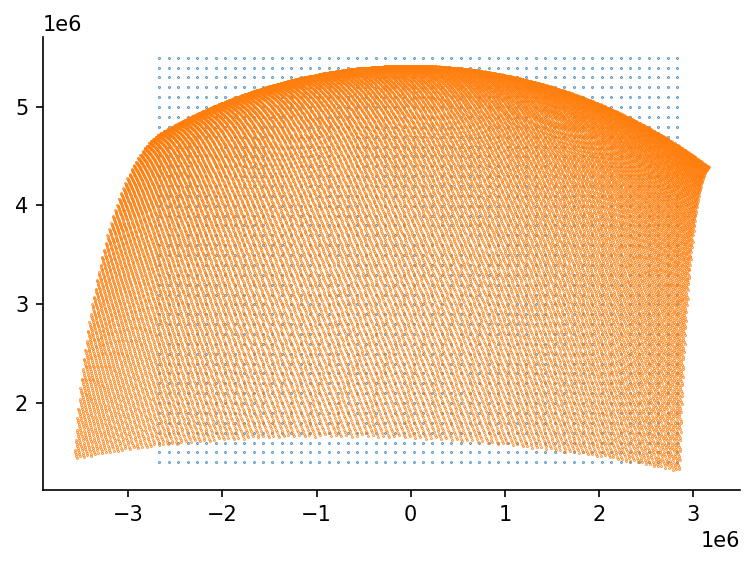

In [32]:
%%time

old_x_positions, old_y_positions = [elem.flatten() for elem in np.meshgrid(da.x.values[::100], da.y.values[::100], indexing='ij')]
new_x_positions, new_y_positions = df_new_coords['x'][::100], df_new_coords['y'][::100]

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(old_x_positions, old_y_positions, s=0.1)
ax.scatter(new_x_positions, new_y_positions, s=0.1)

hlp.hide_spines(ax)

<br>

We'll now use `pyinterp` to take these and use them to carry out the resampling. We'll also create a wrapper for converting the result back into an Xarray object.

In [33]:
#exports
def reproj_with_manual_grid(da, x_coords, y_coords, new_grid):
    
    x_axis = pyinterp.Axis(da.x.values)
    y_axis = pyinterp.Axis(da.y.values)

    grid = pyinterp.Grid2D(x_axis, y_axis, da.data.T)

    reproj_data = (pyinterp
                   .bivariate(grid, x_coords, y_coords)
                   .reshape((len(new_grid['x_coords']), len(new_grid['y_coords'])))
                  )

    return reproj_data

def reproj_to_xarray(da, x_coords, y_coords, new_grid):
    # We'll reproject the data
    reproj_data = reproj_with_manual_grid(da, x_coords, y_coords, new_grid)

    # Then put it in an XArray DataArray
    da_reproj = xr.DataArray(np.flip(reproj_data.T, axis=(0, 1)), 
                             dims=('y', 'x'), 
                             coords={
                                 'x': new_grid['x_coords'][::-1], 
                                 'y': new_grid['y_coords'][::-1]
                             }, 
                             attrs=da.attrs)
    
    return da_reproj

<br>

We'll load the grid back in

In [34]:
with open('../data/intermediate/new_grid_4km_TM.json', 'r') as fp:
    new_grid = json.load(fp)

JSON(new_grid)

<IPython.core.display.JSON object>

<br>

Confirm that the size of the grid definition arrays match the number of coordinates we have

In [35]:
df_new_coords['y'].size == len(new_grid['x_coords'])*len(new_grid['y_coords'])

True

<br>

And finally carry out the reprojection

In [36]:
%%timeit

# if pyinterp not present
try:
    da_reproj = reproj_to_xarray(da, df_new_coords['x'], df_new_coords['y'], new_grid)
except:
    pass

860 ms ± 53.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

Most importantly we'll carry out a visual check that the reprojection was carried out properly.

<ipython-input-37-1ffad43e210d>:7: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())


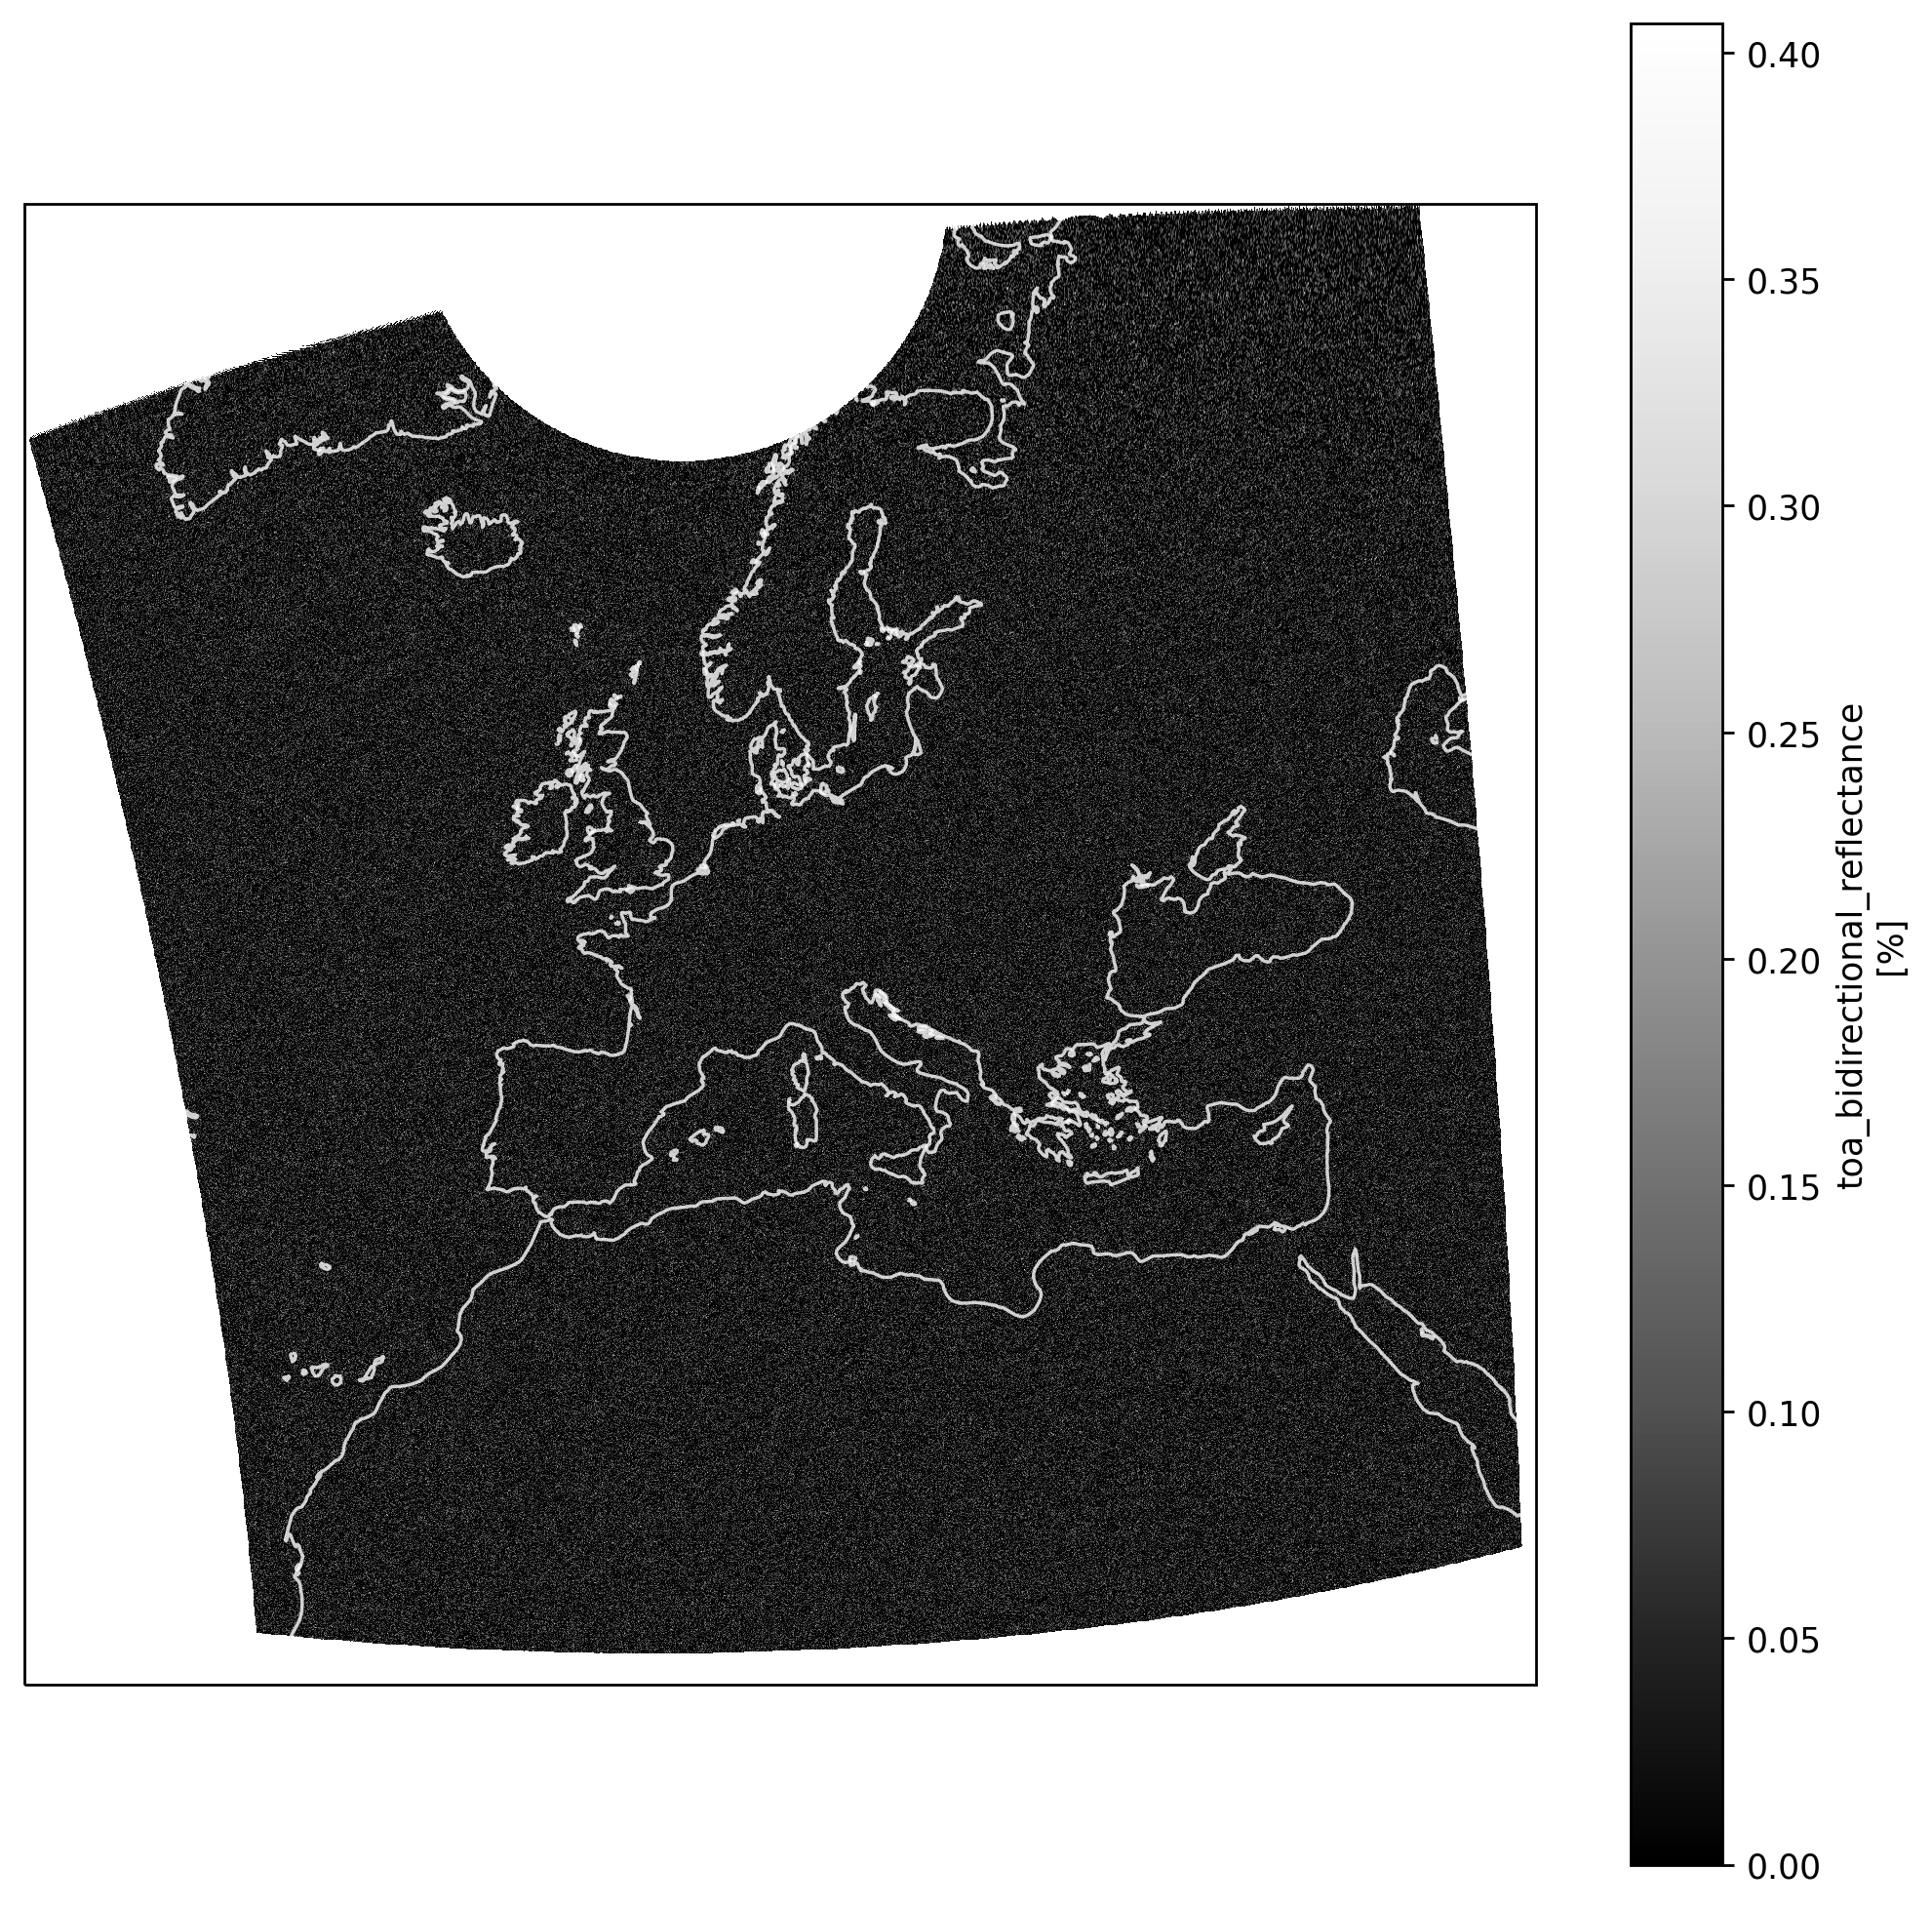

In [37]:
# if pyinterp not present
try:
    da_reproj = reproj_to_xarray(da, df_new_coords['x'], df_new_coords['y'], new_grid)

    # Plotting
    fig = plt.figure(dpi=250, figsize=(10, 10))
    ax = plt.axes(projection=ccrs.TransverseMercator())

    da_reproj.plot.imshow(ax=ax, cmap='Greys_r')

    ax.coastlines(resolution='50m', alpha=0.8, color='white')
except:
    pass

<br>

### Reprojection Wrappers

We'll now wrap the individual steps of our resampling approaches within some standalone functions

In [38]:
#exports
def full_scene_pyresample(native_fp):
    # Loading scene
    scene = load_scene(native_fp)
    dataset_names = scene.all_dataset_names()
    scene.load(dataset_names)
    
    # Constructing target area definition
    tm_area_def = construct_TM_area_def(scene)
    
    # Reprojecting
    reproj_vars = list()

    for dataset_name in dataset_names:
        da = scene[dataset_name].sortby('y', ascending=False).sortby('x')
        num_y_pixels, num_x_pixels = da.shape
        seviri_area_def = get_seviri_area_def(native_fp, num_x_pixels=num_x_pixels, num_y_pixels=num_y_pixels)
        
        resampler = satpy.resample.KDTreeResampler(seviri_area_def, tm_area_def)
        da_reproj = resampler.resample(da)
        reproj_vars += [da_reproj]
    
    variable_idx = pd.Index(dataset_names, name='variable')
    
    ds_reproj = (xr
                 .concat(reproj_vars, dim=variable_idx)
                 .to_dataset(name='stacked_eumetsat_data')
                 .drop(labels='crs')
                )
    
    return ds_reproj

def full_scene_pyinterp(native_fp, new_x_coords, new_y_coords, new_grid_fp):
    # Loading data
    scene = load_scene(native_fp)
    dataset_names = scene.all_dataset_names()
    scene.load(dataset_names)
    
    with open(new_grid_fp, 'r') as fp:
        new_grid = json.load(fp)

    # Correcting x coordinates
    seviri_area_def = get_seviri_area_def(native_fp)
    area_extent = seviri_area_def.area_extent
    x_offset = calculate_x_offset(native_fp)

    width = scene['HRV'].x.size
    corrected_x_coords = np.linspace(area_extent[2], area_extent[0], width)
    scene['HRV'] = scene['HRV'].assign_coords({'x': corrected_x_coords})
    
    # Reprojecting
    reproj_vars = list()

    for dataset_name in dataset_names:
        da_reproj = reproj_to_xarray(scene[dataset_name], new_x_coords, new_y_coords, new_grid)
        reproj_vars += [da_reproj]
    
    variable_idx = pd.Index(dataset_names, name='variable')
    ds_reproj = xr.concat(reproj_vars, dim=variable_idx).to_dataset(name='stacked_eumetsat_data')
    
    return ds_reproj

<br>

We'll then create a new `Reprojector` class which allows us to easily switch between the two and also stores the cached coordinates required for the `pyinterp` approach

In [ ]:
#exports
class Reprojector:
    def __init__(self, new_coords_fp=None, new_grid_fp=None):
        if new_coords_fp is None and new_grid_fp is None:
            return
        
        df_new_coords = pd.read_csv(new_coords_fp)
        
        self.new_x_coords = df_new_coords['x']
        self.new_y_coords = df_new_coords['y']
        self.new_grid_fp = new_grid_fp
        
        return
    
    def reproject(self, native_fp, reproj_library='pyresample'):
        if reproj_library == 'pyinterp':
            ds_reproj = full_scene_pyinterp(native_fp, self.new_x_coords, self.new_y_coords, self.new_grid_fp)
        elif reproj_library == 'pyresample':
            ds_reproj = full_scene_pyresample(native_fp)
        else:
            raise ValueError(f'`reproj_library` must be one of: pyresample, pyinterp. {reproj_library} can not be passed.')
            
        return ds_reproj

In [39]:
new_coords_fp = f'{intermediate_data_dir}/reproj_coords_TM_4km.csv'
new_grid_fp='../data/intermediate/new_grid_4km_TM.json'

reprojector = Reprojector(new_coords_fp, new_grid_fp)

reprojector

<br>

We'll quickly compare the speeds between the `pyinterp` ...

In [40]:
%%capture --no-stdout
%%timeit 

# in case pyinterp is not available:
try:
    ds_reproj = reprojector.reproject(native_fp, reproj_library='pyinterp')
except:
    pass

8.65 s ± 908 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

... and the `pyresample` methods

In [41]:
%%capture --no-stdout
%%timeit 

reprojector = Reprojector()
ds_reproj = reprojector.reproject(native_fp, reproj_library='pyresample')

6.75 s ± 665 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

We'll also visualise one of the reprojections to double-check that everything is working as expected

In [ ]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

ds_reproj['stacked_eumetsat_data'].sel(variable='HRV').plot.imshow(ax=ax, cmap='Greys_r')

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<ipython-input-44-7b583bd69917>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


In [43]:
#hide
from nbdev.export import *
notebook2script('02_reprojection.ipynb')

Converted 02_reprojection.ipynb.
